In [1]:
import pandas as pd

In [2]:
df_sales = pd.read_csv('SalesTransaction.csv')

In [3]:
df_sales

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom
...,...,...,...,...,...,...,...,...
536345,C536548,12/1/2018,22168,Organiser Wood Antique White,18.96,-2,12472.0,Germany
536346,C536548,12/1/2018,21218,Red Spotty Biscuit Tin,14.09,-3,12472.0,Germany
536347,C536548,12/1/2018,20957,Porcelain Hanging Bell Small,11.74,-1,12472.0,Germany
536348,C536548,12/1/2018,22580,Advent Calendar Gingham Sack,16.35,-4,12472.0,Germany


# Data Cleansing
Eksekusi 2 code dibawah ini

In [4]:
# 1. Ubah kolom Date menjadi tipe datetime
df_sales['Date']= pd.to_datetime(df_sales['Date'])

# 2. Buang semua transaksi yang memiliki quantity negative atau yang TransactionNo diawali dengan C
df_sales = df_sales[df_sales['TransactionNo'].str[0]!='C']

# Top Contributing products

Pada retail store, ada banyak jenis barang yang dijual.
Memahami karakteristik penjualan di setiap barang sangatlah penting.  
Barang-barang dengan minat tinggi dari customer menjadi kunci bisnis untuk meraih untung.
Barang-barang dengan minat rendah dari masyarakat akan menjadi beban dari usaha apabila bisnis menyetok terlalu banyak.

Salah satu metode segmentasi yang digunakan adalah menggunakan segmentasi berdasarkan :
- Volume transaksi : Berapa banyak transaksi yang melibatkan suatu produk (Tidak mempedulikan banyaknya barang dalam 1 transaksi)
- Revenue total : Berapa dolar revenue yang dihasilkan dari penjualan produk ini.

Buatlah segmentasi produk berdasarkan volume dan revenue total dengan aturan sebagai berikut :

1. total_revenue didefinisikan sebagai perkalian harga barang dengan banyaknya pembelian
2. 20% produk dengan volume transaksi transaksi tertinggi masuk kategori "Popular". 20 - 80% Masuk kategori "Normal" dan sisanya masuk ke kategori "Low"
3. 20% produk dengan total revenue tertinggi masuk kategori "Popular". 20 - 80% Masuk kategori "Normal" dan sisanya masuk ke kategori "Low"
4. Berdasarkan penggabungan segmentasi no.2 dan no.3, apabila suatu produk Popular dari segi volume transaksi dan total revenue, maka segmentasi final dari produk tersebut adalah "Super Popular". Apabila salah satu atribut populer sementara atribut lainnya normal, maka segmentasi finalnya adalah "Popular". Apabila kedua atributnya "Low", maka segmentasi finalnya adalah "Low". Semua kombinasi lain selain yang disebutkan masuk ke kategori "Normal"

## Pertanyaan
1. Barang tipe apa yang masuk ke kategori super populer pada bulan November 2019?
2. Apakah barang yang populer di November 2019 sama dengan barang yang populer di Desember 2018?
3. Apakah barang yang masuk kategori super populer di november sama dengan barang super populer di July ?

## Jawaban:

In [5]:
import pandas as pd
import numpy as np

# Load data
df_sales = pd.read_csv('SalesTransaction.csv')

# Pastikan kolom Date dalam format datetime
df_sales['Date'] = pd.to_datetime(df_sales['Date'])

# Hapus transaksi negatif atau transaksi yang diawali dengan 'C'
df_sales = df_sales[df_sales['TransactionNo'].str[0] != 'C']
df_sales = df_sales[df_sales['Quantity'] > 0]

# Hapus duplikasi
df_sales.drop_duplicates(inplace=True)

# Hitung total revenue
df_sales['TotalRevenue'] = df_sales['Price'] * df_sales['Quantity']

# Hitung Volume Transaksi & Revenue per Produk
product_summary = df_sales.groupby('ProductNo').agg(
    Volume=('TransactionNo', 'nunique'),  # Banyaknya transaksi unik per produk
    TotalRevenue=('TotalRevenue', 'sum')  # Total revenue dari semua transaksi produk
).reset_index()

# Segmentasi berdasarkan Volume
volume_quantiles = product_summary['Volume'].quantile([0.2, 0.8]).values
product_summary['VolumeSegment'] = np.select(
    [product_summary['Volume'] >= volume_quantiles[1],
     product_summary['Volume'] >= volume_quantiles[0]],
    ['Popular', 'Normal'],
    default='Low'
)

# Segmentasi berdasarkan Revenue
revenue_quantiles = product_summary['TotalRevenue'].quantile([0.2, 0.8]).values
product_summary['RevenueSegment'] = np.select(
    [product_summary['TotalRevenue'] >= revenue_quantiles[1],
     product_summary['TotalRevenue'] >= revenue_quantiles[0]],
    ['Popular', 'Normal'],
    default='Low'
)

# Final Segmentasi
conditions = [
    (product_summary['VolumeSegment'] == 'Popular') & (product_summary['RevenueSegment'] == 'Popular'),
    (product_summary['VolumeSegment'] == 'Popular') | (product_summary['RevenueSegment'] == 'Popular'),
    (product_summary['VolumeSegment'] == 'Low') & (product_summary['RevenueSegment'] == 'Low')
]
choices = ['Super Popular', 'Popular', 'Low']
product_summary['FinalSegment'] = np.select(conditions, choices, default='Normal')

# Filter untuk bulan tertentu
def get_super_popular_products(month, year):
    filtered_data = df_sales[(df_sales['Date'].dt.month == month) & (df_sales['Date'].dt.year == year)]
    product_counts = filtered_data.groupby('ProductNo').agg(
        Volume=('TransactionNo', 'nunique'),
        TotalRevenue=('TotalRevenue', 'sum')
    ).reset_index()

    # Join dengan segmentasi
    merged_data = product_counts.merge(product_summary, on='ProductNo', how='left')
    return merged_data[merged_data['FinalSegment'] == 'Super Popular']

### 1. Barang tipe apa yang masuk ke kategori super populer pada bulan November 2019?

Kita bisa mulai dengan mencari nama produk untuk kategori "Super Produk" pada bulan November 2019

In [6]:
# Ambil produk Super Popular di November 2019
super_popular_nov_2019_list = get_super_popular_products(11, 2019)[['ProductNo', 'TotalRevenue_x', 'Volume_x']]

# Gabungkan dengan ProductName dari df_sales
super_popular_nov_2019_list = super_popular_nov_2019_list.merge(
    df_sales[['ProductNo', 'ProductName']].drop_duplicates(),
    on='ProductNo',
    how='left'
)

# Tampilkan hasil
super_popular_nov_2019_list

,ProductNo,TotalRevenue_x,Volume_x,ProductName
0,10133,1807.14,22,Colouring Pencils Brown Tube
1,15036,5324.15,42,Assorted Colours Silk Fan
2,15056N,2459.19,37,Edwardian Parasol Natural
3,16161P,5482.75,14,Wrap English Rose
4,16237,8549.12,58,Sleeping Cat Erasers
...,...,...,...,...
570,85099F,5526.12,72,Jumbo Bag Strawberry
571,85123A,57380.14,260,Cream Hanging Heart T-Light Holder
572,85150,3934.01,52,Ladies & Gentlemen Metal Sign
573,85152,4872.75,49,Hand Over The Chocolate Sign


- Terdapat 575 Produk dengan kategori "Super Populer" pada November 2019
- Nama-nama dari produk tersebut bisa dilihat pada tabel di atas. Tiga di antaranya adalah Colouring Pencils Brown Tube, Assorted Colours Silk Fan, dan Edwardian Parasol Natural

Lalu selanjutnya kita bisa mencari produk apa yang paling diminati, sehingga memberikan Revenue terbanyak

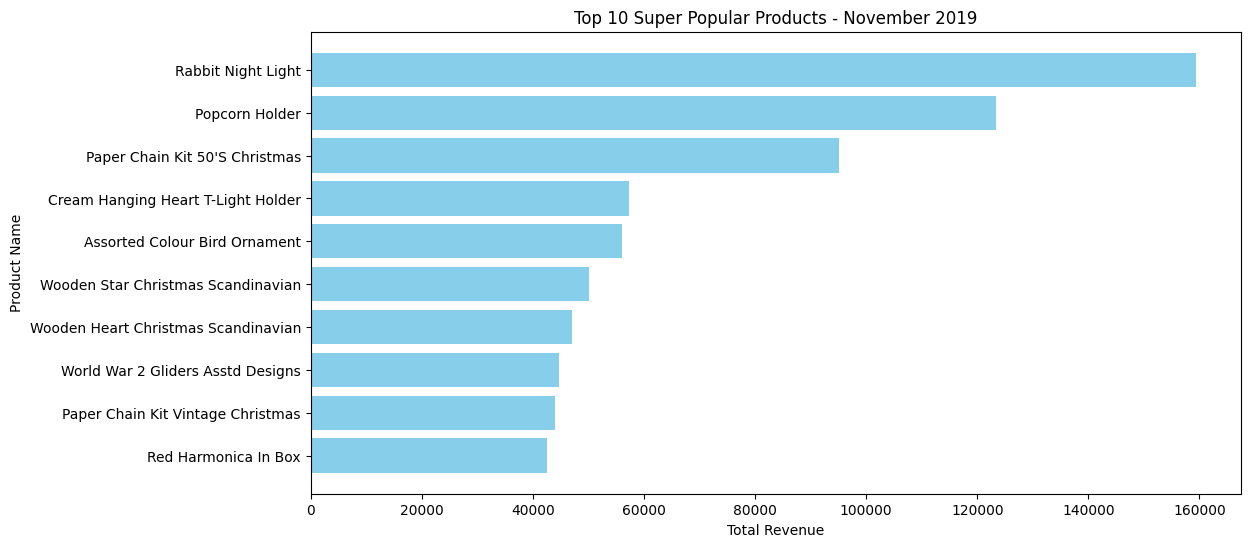

In [7]:
import matplotlib.pyplot as plt

# Ambil 10 produk teratas berdasarkan revenue
top_10_nov = super_popular_nov_2019_list.sort_values(by='TotalRevenue_x', ascending=False).head(10)

plt.figure(figsize=(12,6))
plt.barh(top_10_nov['ProductName'], top_10_nov['TotalRevenue_x'], color='skyblue')
plt.xlabel("Total Revenue")
plt.ylabel("Product Name")
plt.title("Top 10 Super Popular Products - November 2019")
plt.gca().invert_yaxis()
plt.show()

- Grafik memberikan Top 10 Produk yang paling banyak menghasilkan Revenue pada bulan November 2019
- Bisa kita lihat bahwa Produk "Rabbit Night Light" merupakan Produk dengan Revenue yang paling banyak di bulan November 2019

#### Kesimpulan Pertanyaan Nomor 1 (Top Contributing products):
1. Terdapat 575 produk yang termasuk dalam kategori Super Populer pada bulan November 2019.
2. Berdasarkan analisis nama produk, banyak di antaranya memiliki nuansa musiman, terutama bertema Natal dan liburan akhir tahun, seperti Christmas Decoration, Festive Bunting, Toilet Roll Natal, dan sebagainya.

#### Insight Pertanyaan Nomor 1 (Top Contributing products):
1. Banyaknya barang Super Popular di bulan November 2019 menunjukkan adanya lonjakan permintaan di bulan tersebut.
2. Kemungkinan karena persiapan liburan akhir tahun seperti Natal dan Tahun Baru, yang meningkatkan jumlah transaksi di industri retail tersebut.
3. Retailer dapat memanfaatkan tren ini dengan mengoptimalkan stok dan promosi produk bertema liburan sejak awal Q4, agar bisa memaksimalkan penjualan menjelang akhir tahun.

### 2. Apakah barang yang populer di November 2019 sama dengan barang yang populer di Juli 2019?

In [8]:
# Filter data Populer di November 2019
popular_nov_2019 = df_sales[(df_sales['Date'].dt.month == 11) & (df_sales['Date'].dt.year == 2019)]
popular_nov_summary = popular_nov_2019.groupby('ProductNo').agg(
    Volume=('TransactionNo', 'nunique'),
    TotalRevenue=('TotalRevenue', 'sum')
).reset_index()
popular_nov_summary = popular_nov_summary.merge(product_summary[['ProductNo', 'FinalSegment']], on='ProductNo', how='left')
popular_nov_2019 = popular_nov_summary[popular_nov_summary['FinalSegment'] == 'Popular']

# Filter data Populer di Juli 2019
popular_jul_2019 = df_sales[(df_sales['Date'].dt.month == 7) & (df_sales['Date'].dt.year == 2019)]
popular_jul_summary = popular_jul_2019.groupby('ProductNo').agg(
    Volume=('TransactionNo', 'nunique'),
    TotalRevenue=('TotalRevenue', 'sum')
).reset_index()
popular_jul_summary = popular_jul_summary.merge(product_summary[['ProductNo', 'FinalSegment']], on='ProductNo', how='left')
popular_jul_2019 = popular_jul_summary[popular_jul_summary['FinalSegment'] == 'Popular']

# Cari irisan produk
same_nov_jul = popular_nov_2019['ProductNo'].isin(popular_jul_2019['ProductNo']).sum()

In [9]:
print(f"Jumlah barang Popular di November 2019: {len(popular_nov_2019)}")
print(f"Jumlah barang Popular di Juli 2019: {len(popular_jul_2019)}")
print(f"Jumlah barang Popular di November 2019 yang juga ada di Juli 2019: {same_nov_jul}")

Jumlah barang Popular di November 2019: 326
Jumlah barang Popular di Juli 2019: 314
Jumlah barang Popular di November 2019 yang juga ada di Juli 2019: 302


- Terdapat sekitar 326 produk dengan kategori "Populer" di bulan November 2019
- Terdapat sekitar 314 produk dengan kategori "Populer" di bulan Juli 2019
- Terdapat sekitar 302 produk yang sama di bulan November 2019 dengan Juli 2019

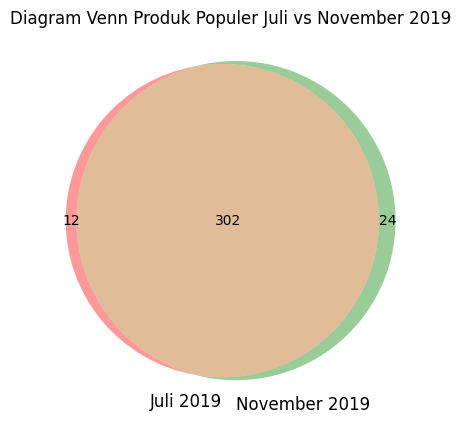

In [10]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Konversi ke set agar bisa dihitung irisan untuk diagram Venn
set_nov = set(popular_nov_2019['ProductNo'])
set_jul = set(popular_jul_2019['ProductNo'])
overlap = set_nov & set_jul

plt.figure(figsize=(5, 5))
venn2(subsets=(len(set_jul - overlap), len(set_nov - overlap), len(overlap)),
      set_labels=("Juli 2019", "November 2019"))
plt.title("Diagram Venn Produk Populer Juli vs November 2019")
plt.show()

- Berdasarkan Diagram Venn, terdapat sekitar 302 produk dengan kategori 'Populer' yang beririsan pada November 2019 dengan Juli 2019
- Terdapat 24 produk dengan kategori 'Populer' pada November 2019 yang berbeda dengan Juli 2019
- Terdapat 12 produk dengan kategori 'Populer' pada Juli 2019 yang berbeda dengan November 2019

#### Kesimpulan Pertanyaan Nomor 2 (Top Contributing products):
1. Dari total produk populer di November 2019 dan Juli 2019, terdapat 302 produk yang sama. Artinya, sebagian besar produk populer di bulan November 2019 juga sudah populer sejak bulan Juli 2019.
2. Hanya terdapat 24 produk baru di November 2019 yang tidak muncul sebagai populer di Juli, dan 12 produk di Juli 2019 yang tidak lagi masuk daftar populer di November. Ini menunjukkan bahwa pergeseran minat konsumen tidak terlalu drastis.

#### Insight Pertanyaan Nomor 2 (Top Contributing products):
1. Produk-produk populer cenderung tetap diminati sepanjang waktu, sehingga bisa dikategorikan sebagai produk dengan demand stabil. Retailer bisa menjadikannya sebagai produk andalan (core inventory) karena penjualannya konsisten.
2. Retailer dapat memastikan stok produk populer tetap tersedia sepanjang tahun
3. Retailer dapat menyesuaikan stok produk musiman secara tepat waktu, seperti mempersiapkan stok lebih banyak menjelang akhir tahun.

### 3. Apakah barang yang masuk kategori super populer di november sama dengan barang super populer di July?

In [11]:
# Filter produk Super Populer untuk bulan November dan Juli 2019
def get_super_popular_products(month, year):
    filtered_data = df_sales[(df_sales['Date'].dt.month == month) & (df_sales['Date'].dt.year == year)]
    product_counts = filtered_data.groupby('ProductNo').agg(
        Volume=('TransactionNo', 'nunique'),
        TotalRevenue=('TotalRevenue', 'sum')
    ).reset_index()

    # Gabungkan dengan segmentasi
    merged_data = product_counts.merge(product_summary, on='ProductNo', how='left')
    return merged_data[merged_data['FinalSegment'] == 'Super Popular']

# Ambil data Super Populer untuk Nov dan Jul 2019
super_popular_nov_2019 = get_super_popular_products(11, 2019)
super_popular_jul_2019 = get_super_popular_products(7, 2019)

# Hitung irisan produk antara kedua bulan
overlap_super_nov_jul = super_popular_nov_2019['ProductNo'].isin(super_popular_jul_2019['ProductNo']).sum()

In [12]:
print(f"Jumlah barang Super Popular di November 2019: {len(super_popular_nov_2019)}")
print(f"Jumlah barang Super Popular di Juli 2019: {len(super_popular_jul_2019)}")
print(f"Jumlah barang Super Popular di November 2019 yang juga ada di Juli 2019: {overlap_super_nov_jul}")

Jumlah barang Super Popular di November 2019: 575
Jumlah barang Super Popular di Juli 2019: 551
Jumlah barang Super Popular di November 2019 yang juga ada di Juli 2019: 545


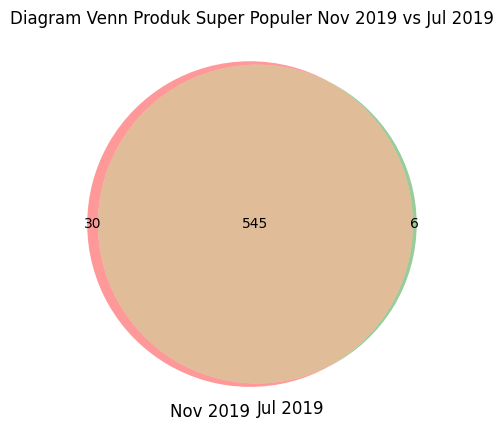

In [13]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
venn2(
    subsets=(
        len(super_popular_nov_2019) - overlap_super_nov_jul,
        len(super_popular_jul_2019) - overlap_super_nov_jul,
        overlap_super_nov_jul
    ),
    set_labels=("Nov 2019", "Jul 2019")
)
plt.title("Diagram Venn Produk Super Populer Nov 2019 vs Jul 2019")
plt.show()

- Berdasarkan Diagram Venn, terdapat sekitar 545 produk dengan kategori 'Super Populer' yang beririsan pada November 2019 dengan Juli 2019
- Terdapat 30 produk dengan kategori 'Super Populer' pada November 2019 yang berbeda dengan Juli 2019
- Terdapat 6 produk dengan kategori 'Super Populer' pada Juli 2019 yang berbeda dengan November 2019

#### Kesimpulan Pertanyaan Nomor 3 (Top Contributing products):
1. Terdapat 545 produk yang tetap berada dalam kategori Super Populer di kedua bulan, menunjukkan adanya konsistensi preferensi pelanggan terhadap produk-produk tertentu selama rentang waktu tersebut.
2. Sedikit perbedaan terjadi antar bulan. Hanya terdapat 30 produk Super Populer di November yang tidak termasuk dalam Super Populer di Juli & 6 produk Super Populer di Juli yang tidak termasuk dalam Super Populer di November.

#### Insight Pertanyaan Nomor 3 (Top Contributing products):
1. Dengan tingginya irisan antara produk Super Populer di kedua bulan, bisnis dapat fokus mempertahankan ketersediaan produk-produk ini karena sudah terbukti performanya tinggi selama periode yang cukup jauh (5 bulan).
2. 30 produk yang hanya Super Populer di November bisa jadi adalah produk musiman, tren baru, atau campaign promosi spesifik bulan tersebut.
3. Produk yang konsisten Super Populer layak menjadi fokus utama untuk stok, promosi, dan bundling.

# Retention Cohort Analysis

Analisis kohort adalah metode analisis yang digunakan untuk mempelajari perilaku konsumen atau pengguna dari kelompok yang sama dalam periode waktu tertentu.   
Contoh Kohort : Kohort kustomer yang bergabung pada bulan mei

Analisis retensi adalah analisis untuk melihat seberapa besar persentase pengguna atau pelanggan yang kembali menggunakan produk atau layanan dalam periode waktu tertentu.

Dengan menganalisis kohort dan retensi, perusahaan atau organisasi dapat mengidentifikasi tren dan pola dalam perilaku pengguna atau pelanggan.

Berikut cuplikan matriks retensi yang akan kalian hasilkan pada bagian ini :

![image.png](attachment:7589fe3f-aebd-4a22-bde4-b0f791dce58c.png)

Cara baca :  
Pada bulan januari, ada 827 customer baru.  
33% dari 827 customer melakukan transaksi 1 bulan kemudian.  
41.4% dari 827 customer melakukan transasksi 2 bulan kemduain.  

Hal ini menunjukkan bahwa sekitar sepertiga customer yang melanjutkan transaksi setelah mendaftar pada bulan januari.  

Sedangkan pada kohort bulan februari, ada 569 customer baru dan hanya 22% customer yang kembali bertransaksi sebulan setelahnya  

Buatlah matriks kohort retensi per bulan menggunakan data dari 1 januari 2019 hingga 30 november 2019
Petunjuk :
1. Hitung tanggal berapa transaksi pertama customer. Disini kita menggunakna asumsi bahwa transaksi pertama pada tahun 2019 adalah transaksi pertama customer.
2. Lakukan iterasi untuk setiap bulan. Ambil berapa banyak customer yang mendaftar dan berapa banyak customer yang sama yang melakukan transaksi di bulan bulan berikutnya.

## Pertanyaan
1. Bagaimana karakteristik pertumbuhan customer baru? Apakah pertumbuhan terus meningkat atau melambat?

2. Setiap bulannya tim marketing menggunakan metode promosi campaign yang berbeda-beda. Bulan mana yang menghasilkan retention paling tinggi?

## Jawaban:

Matriks Kohort Retensi per Bulan (Januari 2019 - November 2019):

In [14]:
# Filter data hanya dari Januari 2019 sampai November 2019
df_2019 = df_sales[(df_sales['Date'] >= '2019-01-01') & (df_sales['Date'] < '2019-12-01')].copy()

# Ambil bulan transaksi dan bulan transaksi pertama customer
df_2019['OrderMonth'] = df_2019['Date'].dt.to_period('M')
df_2019['CohortMonth'] = df_2019.groupby('CustomerNo')['Date'].transform('min').dt.to_period('M')

# Hitung index bulan (bulan ke-0, ke-1, dst setelah first order)
def get_month_diff(df):
    return (df['OrderMonth'].dt.year - df['CohortMonth'].dt.year) * 12 + \
           (df['OrderMonth'].dt.month - df['CohortMonth'].dt.month)

df_2019['MonthIndex'] = get_month_diff(df_2019)

In [15]:
# Hitung jumlah unique customer berdasarkan Cohort dan MonthIndex
cohort_data = df_2019.groupby(['CohortMonth', 'MonthIndex'])['CustomerNo'].nunique().reset_index()

# Pivot ke bentuk matriks
cohort_pivot = cohort_data.pivot(index='CohortMonth', columns='MonthIndex', values='CustomerNo')

# Ambil jumlah customer baru per cohort di bulan ke-0
cohort_sizes = cohort_pivot.iloc[:, 0]

# Hitung rasio retensi
retention_matrix = cohort_pivot.divide(cohort_sizes, axis=0)

# Gabungkan dengan jumlah customer baru untuk tampilan akhir
final_matrix = cohort_pivot.copy()
final_matrix.insert(0, 'Count_new_customer', cohort_sizes)
final_matrix.update(retention_matrix)

# Print hasil matriks retensi
final_matrix.round(3).fillna('')

MonthIndex,Count_new_customer,0,1,2,3,4,5,6,7,8,9,10
CohortMonth,,,,,,,,,,,,
2019-01,827.0,1.0,0.335,0.415,0.374,0.437,0.406,0.375,0.369,0.412,0.407,0.495
2019-02,569.0,1.0,0.225,0.236,0.32,0.301,0.257,0.283,0.313,0.299,0.355,
2019-03,610.0,1.0,0.161,0.251,0.22,0.243,0.179,0.275,0.244,0.298,,
2019-04,397.0,1.0,0.224,0.207,0.219,0.202,0.247,0.247,0.295,,,
2019-05,374.0,1.0,0.184,0.179,0.179,0.214,0.227,0.273,,,,
2019-06,309.0,1.0,0.184,0.149,0.214,0.217,0.294,,,,,
2019-07,242.0,1.0,0.153,0.19,0.219,0.302,,,,,,
2019-08,192.0,1.0,0.198,0.234,0.234,,,,,,,
2019-09,312.0,1.0,0.247,0.34,,,,,,,,


HeatMap Kohort Retensi per Bulan (Januari 2019 - November 2019):

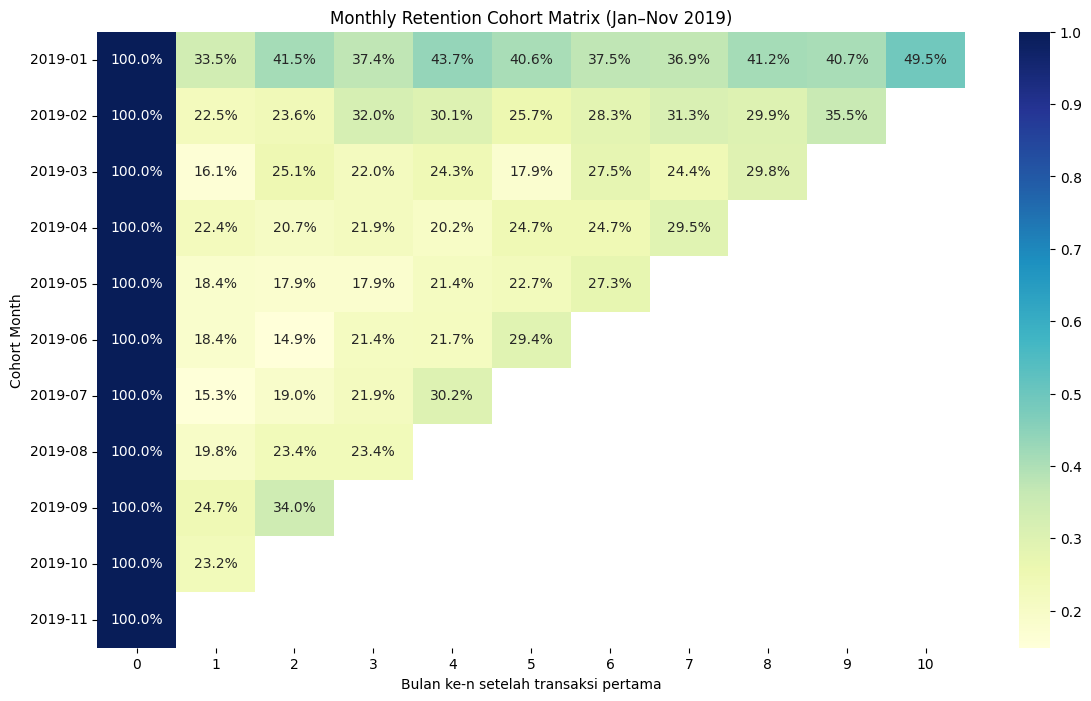

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
sns.heatmap(retention_matrix, annot=True, fmt='.1%', cmap='YlGnBu')
plt.title('Monthly Retention Cohort Matrix (Jan–Nov 2019)')
plt.ylabel('Cohort Month')
plt.xlabel('Bulan ke-n setelah transaksi pertama')
plt.show()

#### Kesimpulan Pertanyaan Nomor 1 (Retention Cohort Analysis):
Kita lihat dari kolom Count_new_customer per bulan (banyaknya customer baru yang pertama kali bertransaksi tiap bulan):

- Jan:	827
- Feb:	569
- Mar:	610
- Apr:	397
- Mei:	374
- Jun:	309
- Jul:	242
- Agu:	192
- Sep:	312
- Okt:	353
- Nov:	334

1. Terlihat bahwa jumlah customer baru menurun secara bertahap dari Januari (827) hingga Juli (242), menunjukkan tren perlambatan akuisisi customer baru di semester pertama.
2. Namun, mulai Agustus hingga November, terdapat sedikit peningkatan kembali (192 → 312 → 353 → 334), yang bisa mengindikasikan adanya strategi marketing yang mulai efektif kembali di kuartal akhir.


#### Insight Pertanyaan Nomor 1 (Retention Cohort Analysis):
1. Pada bulan Januari hingga Juli 2019, pertumbuhan customer baru cenderung melambat. Hal ini menunjukkan bahwa strategi akuisisi customer kemungkinan kurang efektif di pertengahan tahun, bisa jadi karena kompetisi yang meningkat, campaign yang kurang menarik, atau faktor musiman.

2. Retailer perlu mengevaluasi strategi akuisisi pada kuartal kedua dan ketiga, serta menganalisis campaign yang digunakan di kuartal keempat yang terlihat lebih efektif dalam menarik customer baru.

3. Campaign berbasis komunitas (Contoh: "ajak teman dan dapatkan cashback") bisa meningkatkan pertumbuhan secara customer baru

#### Kesimpulan Pertanyaan Nomor 2 (Retention Cohort Analysis):
Retention tertinggi dilihat dari persentase customer yang tetap kembali di bulan ke-1, ke-2, dst. Kita fokus ke bulan ke-1 dan bulan ke-2 sebagai indikator utama retensi jangka pendek:

1. Januari
- Retensi Bulan ke-1: 33.5%
- Retensi Bulan ke-2: 41.5%

2. Februari
- Retensi Bulan ke-1: 22.5%
- Retensi Bulan ke-2: 23.6%

3. Maret
- Retensi Bulan ke-1: 16.1%
- Retensi Bulan ke-2: 25.1%

4. April
- Retensi Bulan ke-1: 22.4%
- Retensi Bulan ke-2: 20.7%

5. Mei
- Retensi Bulan ke-1: 18.5%
- Retensi Bulan ke-2: 17.9%

6. Juni
- Retensi Bulan ke-1: 18.5%
- Retensi Bulan ke-2: 14.9%

7. Juli
- Retensi Bulan ke-1: 15.3%
- Retensi Bulan ke-2: 19.0%

8. Agustus
- Retensi Bulan ke-1: 19.8%
- Retensi Bulan ke-2: 23.4%

9. September
- Retensi Bulan ke-1: 24.7%
- Retensi Bulan ke-2: 34.0%

10. Oktober
- Retensi Bulan ke-1: 23.2%
- Retensi Bulan ke-2: -

11. November
- Retensi Bulan ke-1: -
- Retensi Bulan ke-2: -


1. Januari 2019 menghasilkan retensi paling tinggi baik di bulan ke-1 (33.5%) maupun bulan ke-2 (41.5%).
2. September 2019 juga menunjukkan performa yang sangat baik di bulan ke-2 (34%).

#### Insight Pertanyaan Nomor 2 (Retention Cohort Analysis):
1. Strategi marketing yang dijalankan di Januari dan September dapat dianggap paling berhasil dalam mempertahankan customer. Ini bisa menjadi bahan evaluasi untuk mendaur ulang atau mengembangkan campaign serupa di bulan-bulan berikutnya.
2. Tawarkan promo lanjutan setelah pembelian pertama untuk mendorong transaksi ke-2 dan ke-3
3. Kirimkan notifikasi ulang tahun produk, diskon berdasarkan histori pembelian, atau konten rutin untuk mengingatkan customer kembali bertransaksi.

# Time Series Analysis

Time series analysis adalah analisis untuk melihat trend suatu fenomena berdasarkan waktu.

## Pertanyaan

Pertanyaan 1 :  
Coba totalkan penjualan setiap barang per hari.   
Bagaimana trend penjualan? Apakah ada mengalami kenaikan, penurunan, atau stagnant.

Pertanyaan 2 :  
Lakukan analisis seasonality dengan melihat total order per harinya dari Senin hingga Minggu.  


## Jawaban:

In [17]:
# Agregasi total quantity yang terjual per hari
daily_sales = df_sales.groupby('Date').agg(TotalQuantity=('Quantity', 'sum')).reset_index()

# Tambahkan kolom hari untuk seasonality mingguan
daily_sales['DayOfWeek'] = daily_sales['Date'].dt.day_name()

In [18]:
# Tren penjualan harian dari Desember 2018 hingga Desember 2019
print("Rata-rata penjualan harian (Des 2018 - Des 2019):")
daily_sales['TotalQuantity'].describe()

Rata-rata penjualan harian (Des 2018 - Des 2019):


,TotalQuantity
count,305.000000
mean,18278.196721
std,10618.338369
min,2035.000000
25%,11746.000000
50%,16109.000000
75%,22526.000000
max,93925.000000


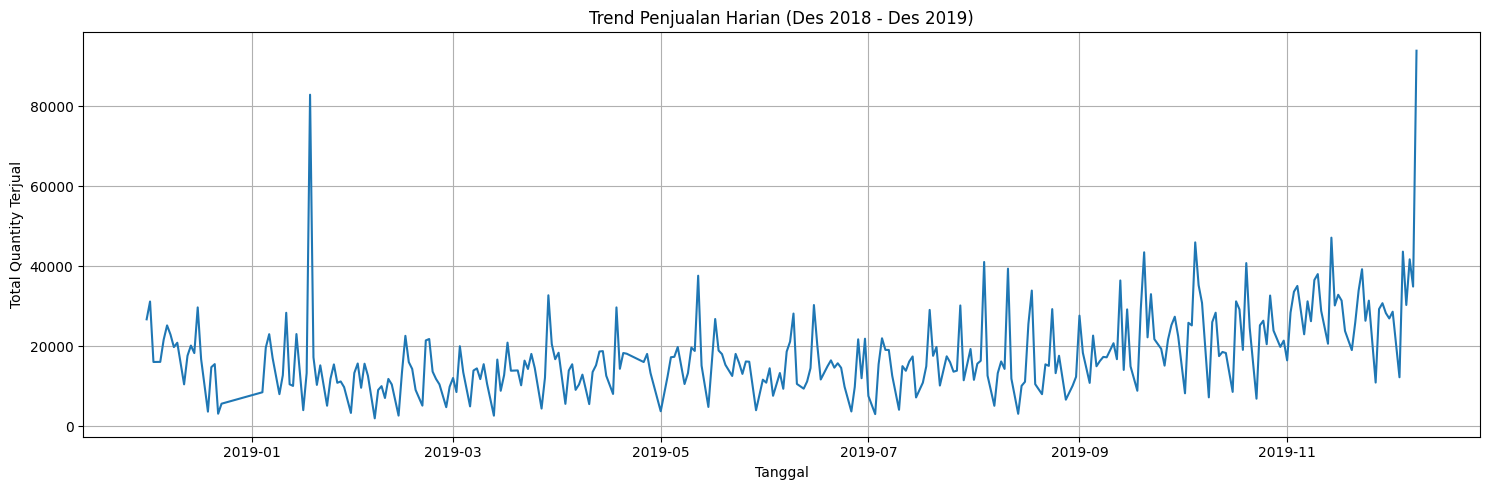

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot tren penjualan harian
plt.figure(figsize=(15, 5))
sns.lineplot(data=daily_sales, x='Date', y='TotalQuantity')
plt.title('Trend Penjualan Harian (Des 2018 - Des 2019)')
plt.xlabel('Tanggal')
plt.ylabel('Total Quantity Terjual')
plt.grid(True)
plt.tight_layout()
plt.show()

Terdapat Lonjakan (Spike) di awal tahun 2019 dan di akhir tahun 2019. Berikut akan dicari tanggal tepatnya serta produk apa yang memberikan kontribusi penjualan yang banyak tersebut.

In [20]:
daily_sales[daily_sales['TotalQuantity'] > 80000]

,Date,TotalQuantity,DayOfWeek
32,2019-01-18,82927,Friday
304,2019-12-09,93925,Monday


#### Kesimpulan Pertanyaan Nomor 1 (Time Analysis):
1. Grafik menunjukkan adanya tren kenaikan penjualan harian, terutama dalam periode sekitar September 2019 hingga Desember 2019
2. Rata-rata penjualan harian adalah sekitar 18.278 unit, dengan nilai maksimum mencapai 93.925 unit dalam satu hari.
3. Tidak terlihat pola penurunan atau stagnasi yang signifikan — menunjukkan pertumbuhan penjualan yang positif dan sehat sepanjang tahun.
4. Terjadi lonjakan tren quantity pada tanggal 18 Januari 2019 dan 9 Desember 2019 dengan quantity di atas 80.000 unit


#### Insight Pertanyaan Nomor 1 (Time Analysis):
1. Pertahankan strategi yang berjalan saat ini, terutama program atau campaign yang dilakukan sejak pertengahan 2019.
2. Retailer dapat mempertimbangkan peningkatan kapasitas operasional dan stok untuk mengantisipasi pertumbuhan permintaan ke depannya.
3. Lonjakan yang terjadi di 18 Januari 2019 kemungkinan terjadi karena produk merupakan produk yang bernuansa Tahun Baru.
4. Lonjakan yang terjadi di 9 Desember 2019 kemungkinan terjadi karena produk merupakan produk yang bernuansa Natal.
5. Periode waktu, dimana lonjakan-lonjakan terjadi bisa dimanfaatkan untuk perencanaan campaign tahunan dengan menjadikan bulan Januari & Desember sebagai momentum utama.
6. Pelanggan yang membeli dalam jumlah besar bisa diklasifikasikan sebagai target loyalitas khusus.

In [21]:
# Rata-rata penjualan per hari dalam seminggu
weekly_pattern = daily_sales.groupby('DayOfWeek')['TotalQuantity'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

print("Rata-rata penjualan per hari dalam seminggu:")
weekly_pattern

Rata-rata penjualan per hari dalam seminggu:


,TotalQuantity
DayOfWeek,
Monday,18057.800000
Tuesday,NaN
Wednesday,9292.580000
Thursday,18485.744681
Friday,21369.826923
Saturday,19280.226415
Sunday,22743.735849


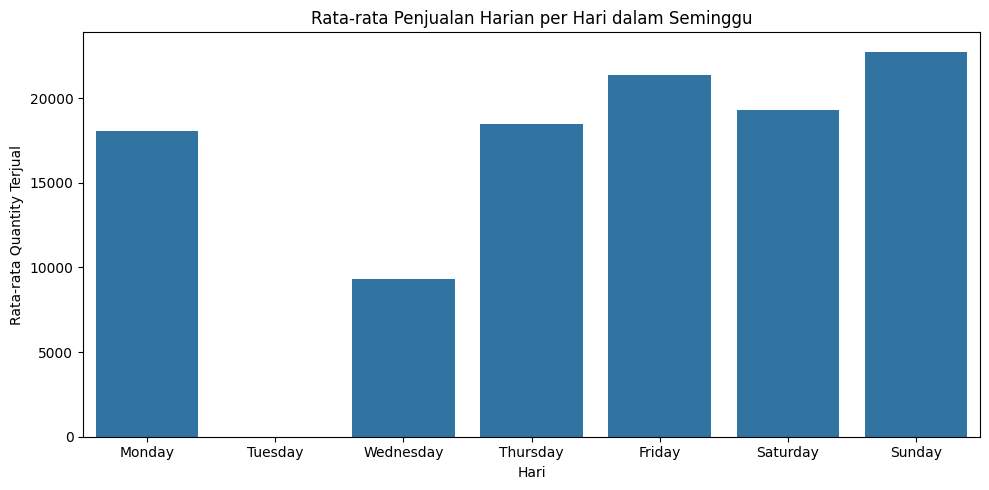

In [22]:
# Plot seasonality berdasarkan hari dalam seminggu
plt.figure(figsize=(10, 5))
sns.barplot(x=weekly_pattern.index, y=weekly_pattern.values)
plt.title('Rata-rata Penjualan Harian per Hari dalam Seminggu')
plt.xlabel('Hari')
plt.ylabel('Rata-rata Quantity Terjual')
plt.tight_layout()
plt.show()

#### Kesimpulan Pertanyaan Nomor 2 (Time Analysis):
1. Hari dengan rata-rata penjualan tertinggi adalah Minggu dan Jumat (masing-masing sekitar >20.000 unit).
2. Hari dengan penjualan paling rendah adalah Rabu (sekitar <10.000 unit)
3. Data Selasa (Tuesday) hilang atau tidak terekam, sehingga perlu diperiksa ulang data mentahnya.

#### Insight Pertanyaan Nomor 2 (Time Analysis):
1. Maksimalkan strategi penjualan (seperti diskon, promo, atau campaign spesial) di hari-hari dengan trafik tinggi: Jumat dan Minggu.
2. Lakukan optimasi untuk meningkatkan penjualan di hari-hari rendah seperti Rabu, misalnya dengan flash sale di tengah pekan.
3. Periksa dan lengkapi data untuk hari Selasa agar analisis tidak bias dan bisa diandalkan untuk perencanaan yang lebih tepat.

# Price Elasticity

Price sensitivity atau sensitifitas harga mengacu pada perubahan permintaan pelanggan akibat naik atau turunya harga suatu produk.

Pada bagian ini anda akan diminta untuk melakukan analisis terhadap suatu produk yang penjualannya sangat dipengaruhi oleh harga.

## Pertanyaan

Pertanyaan 1 :   
Produk apa yang paling sering mengalami perubahan harga?   
Hitunglah banyaknya harga unik di setiap produk dan ambil daftar produk yang pernah terjual dengan setidaknya 10 variasi harga yang berbeda.

Price Elasticity akan semakin baik dianalisis ketika lebih banyak variasi harga yang muncul.

Pertanyaan 2 :   
Dari semua produk yang terambil dari step 1, hitung lah korelasi antara harga dengan quantity untuk setiap barang.  
Barang manakah yang memiliki korelasi paling negatif?  

Pertanyaan 3 :
Buatlah scatter plot antara harga dan quantity untuk barang dari soal sebelumnya.  
Apabila produk tersebut mengalami kenaikan harga, kira-kira apa yang akan terjadi dengan penjualan ?

## Jawaban:

In [23]:
# Hitung jumlah variasi harga unik per produk
price_variation = df_sales.groupby('ProductName')['Price'].nunique().reset_index()

# Ganti nama kolom agar lebih jelas
price_variation.columns = ['ProductName', 'UniquePriceCount']

# Filter hanya produk yang memiliki setidaknya 10 variasi harga
products_with_10_price_variations = price_variation[price_variation['UniquePriceCount'] >= 10]

# Sort secara descending berdasarkan jumlah variasi harga
products_with_10_price_variations = products_with_10_price_variations.sort_values(by='UniquePriceCount', ascending=False)

In [24]:
print(f"Jumlah produk yang memiliki setidaknya 10 variasi harga berbeda: {len(products_with_10_price_variations)}\n")
print("Daftar produk dengan variasi harga terbanyak:")
products_with_10_price_variations.head(10)

Jumlah produk yang memiliki setidaknya 10 variasi harga berbeda: 700

Daftar produk dengan variasi harga terbanyak:


,ProductName,UniquePriceCount
694,Chilli Lights,23
796,Cook With Wine Metal Sign,20
1584,Hot Water Bottle Tea And Sympathy,20
967,Doormat Red Retrospot,19
2124,Pack Of 12 London Tissues,19
965,Doormat New England,19
2801,Scottie Dog Hot Water Bottle,19
1112,Fawn Blue Hot Water Bottle,19
2223,Party Bunting,19
1312,Gin And Tonic Diet Metal Sign,19


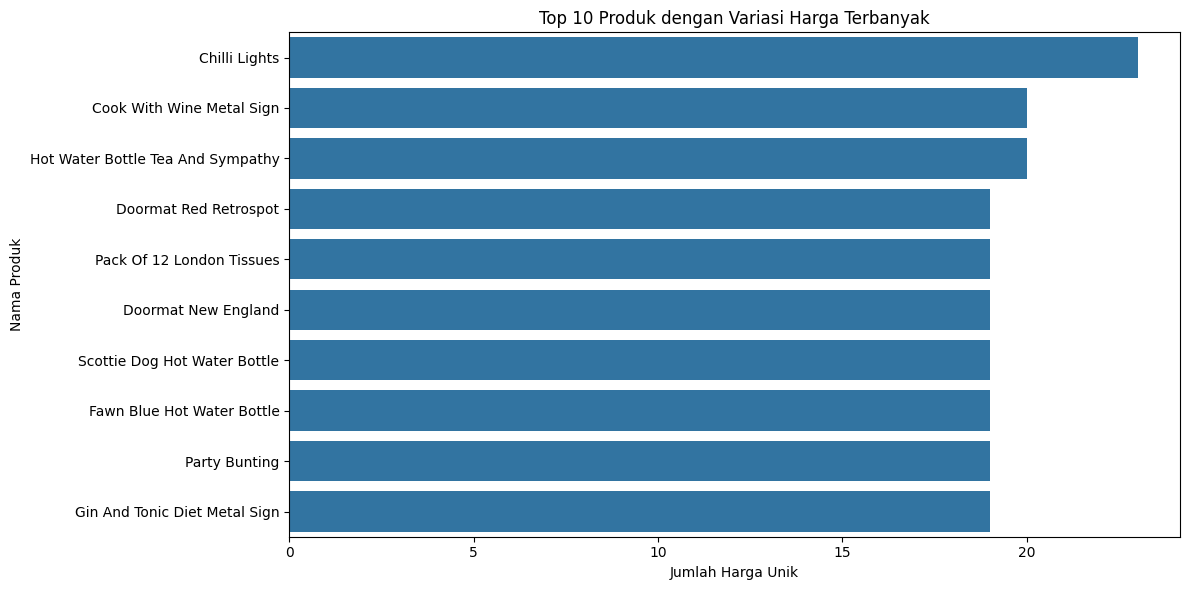

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(
    data=products_with_10_price_variations.head(10),
    x='UniquePriceCount',
    y='ProductName',
)
plt.title('Top 10 Produk dengan Variasi Harga Terbanyak')
plt.xlabel('Jumlah Harga Unik')
plt.ylabel('Nama Produk')
plt.tight_layout()
plt.show()

#### Kesimpulan Pertanyaan Nomor 1 (Price Elasticity):
1. Terdapat 700 produk yang pernah dijual dengan setidaknya 10 variasi harga yang berbeda sepanjang periode Desember 2018 hingga Desember 2019.

2. Produk dengan variasi harga terbanyak adalah "Chilli Lights" dengan 23 variasi harga berbeda, diikuti oleh "Cook With Wine Metal Sign" dan "Hot Water Bottle Tea And Sympathy", masing-masing dengan 20 variasi harga.

3. Mayoritas dari produk dengan variasi harga tinggi adalah produk dekoratif atau hadiah musiman, seperti lampu, signage logam, botol air panas, dan aksesori rumah.

#### Insight Pertanyaan Nomor 1 (Price Elasticity):
1. Produk seperti Chilli Lights, Cook With Wine Metal Sign, dan Hot Water Bottle Tea And Sympathy yang sering mengalami perubahan harga menunjukkan bahwa perusahaan mungkin telah menguji berbagai strategi harga untuk mencari titik optimal.
2. Banyaknya variasi harga dapat menunjukkan bahwa permintaan cukup responsif terhadap perubahan harga (price sensitive).
3. Terapkan strategi diskon atau bundling pada produk-produk dengan permintaan yang elastis di momen-momen tertentu, seperti musim liburan atau akhir tahun.

In [26]:
# Filter data penjualan untuk hanya produk dengan ≥10 variasi harga
chosen_product = products_with_10_price_variations['ProductName']
df_elastic = df_sales[df_sales['ProductName'].isin(chosen_product)]

# Hitung korelasi antara harga dan quantity untuk tiap produk
hasil_korelasi = []

for produk in df_elastic['ProductName'].unique():
    df_produk = df_elastic[df_elastic['ProductName'] == produk]

    # Pastikan ada cukup variasi untuk korelasi
    if df_produk['Price'].nunique() > 1 and df_produk['Quantity'].nunique() > 1:
        korelasi = df_produk['Price'].corr(df_produk['Quantity'])
        hasil_korelasi.append({
            'ProductName': produk,
            'Correlation': korelasi
        })

# Ubah menjadi DataFrame
df_korelasi = pd.DataFrame(hasil_korelasi)

# Urutkan berdasarkan korelasi paling negatif
df_korelasi_terurut = df_korelasi.sort_values(by='Correlation')

# Tampilkan 10 produk paling sensitif terhadap harga
print("Top 10 Produk dengan Korelasi Paling Negatif antara Harga dan Quantity:")
df_korelasi_terurut.head(10)

Top 10 Produk dengan Korelasi Paling Negatif antara Harga dan Quantity:


,ProductName,Correlation
211,Set Of 2 Tea Towels Ping Microwave,-0.476031
8,Squarecushion Cover Pink Union Jack,-0.461947
206,Pizza Plate In Box,-0.449962
696,Large Cake Towel Pink Spots,-0.439484
2,Bag 500g Swirly Marbles,-0.436841
600,Multicolour Spring Flower Mug,-0.411175
472,Swiss Roll Towel Chocolate Spots,-0.400704
4,T-Light Holder White Lace,-0.392285
242,Home Garland Painted Zinc,-0.351573
203,6 Ribbons Empire,-0.348786


#### Kesimpulan Pertanyaan Nomor 2 (Price Elasticity):
1. Dari 700 produk yang memiliki setidaknya 10 variasi harga, terdapat beberapa produk yang menunjukkan korelasi negatif kuat antara harga dan jumlah pembelian. Produk dengan korelasi paling negatif adalah:
- Set Of 2 Tea Towels Ping Microwave (-0.476)
- Squarecushion Cover Pink Union Jack (-0.462)
- Pizza Plate In Box (-0.450)

2. Nilai korelasi negatif menunjukkan bahwa ketika harga produk naik, kuantitas penjualan turun secara signifikan, menandakan bahwa produk tersebut sangat sensitif terhadap perubahan harga atau memiliki price elasticity tinggi.

#### Insight Pertanyaan Nomor 2 (Price Elasticity):
1. Produk-produk dengan korelasi negatif tinggi sebaiknya dimasukkan dalam daftar produk sensitif harga. Ini penting karena konsumen akan lebih responsif terhadap diskon atau kenaikan harga pada produk ini.
2. Karena produk ini sangat elastis, menaikkan harga tanpa mempertimbangkan dampaknya bisa menyebabkan penurunan penjualan yang tajam.
3. Ketika harga sedang rendah, maksimalkan strategi pemasaran seperti email blast atau promosi media sosial untuk memanfaatkan peluang volume pembelian yang tinggi.

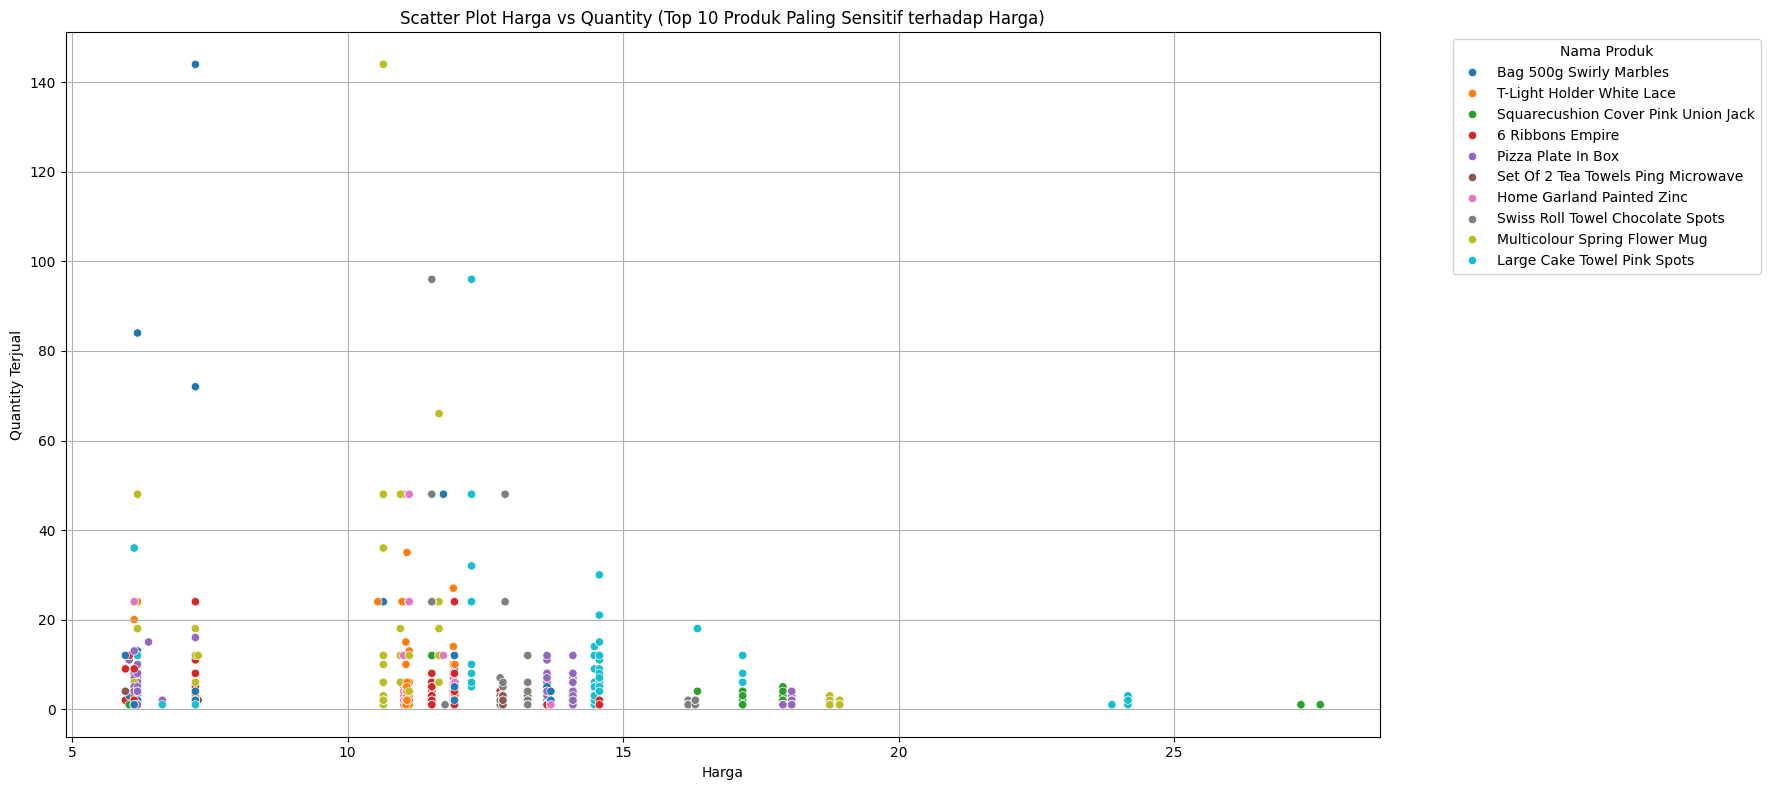

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ambil 5 produk dengan korelasi paling negatif
produk_teratas = df_korelasi_terurut.head(10)['ProductName'].tolist()

# Filter data asli hanya untuk produk-produk tersebut
df_plot = df_sales[df_sales['ProductName'].isin(produk_teratas)]

# Plot scatter antara harga dan quantity
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df_plot, x='Price', y='Quantity', hue='ProductName')
plt.title('Scatter Plot Harga vs Quantity (Top 10 Produk Paling Sensitif terhadap Harga)')
plt.xlabel('Harga')
plt.ylabel('Quantity Terjual')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Nama Produk', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


#### Kesimpulan Pertanyaan Nomor 3 (Price Elasticity):
1. Produk-produk yang masuk dalam Top 10 sensitif terhadap harga cenderung menunjukkan penurunan quantity yang signifikan ketika harga naik.
2. Scatter plot menunjukkan pola menurun pada banyak titik antara harga dan quantity.
3. Apabila terjadi kenaikan harga, maka jumlah unit terjual (quantity) cenderung menurun tajam.

#### Insight Pertanyaan Nomor 3 (Price Elasticity):
1. Hindari menaikkan harga secara langsung untuk produk-produk ini.
2. Karena pembeli pada produk ini sangat peka terhadap perubahan harga, mereka akan:
- Mengurangi pembelian
- Mencari alternatif yang lebih murah
- Menunda pembelian

# Basket Size Analysis

Ketika seorang pelanggan e-commerce menekan "add to cart", maka barang tersebut akan disimpan dalam sebuah "basket".  
Ketika melakukan checkout, maka semua barang dalam basket tersebut akan diproses dan dikirimkan.  
Ukuran dari basket dapat diukur melalui nilai GMV (Gross merchandise volume) yang merupakan total harga barang yang dibeli.  
Contoh :
Pada tanggal 1 januari 2012
Tuan A membeli 1 shampoo seharga 15ribu dan 2 sabun seharga 20ribu masing-masing. Maka basket size tuan A adalah 55ribu rupiah.
Nyonya B hanya membeli 1 cemilan seharga 20 ribu, maka basket size dari nyonya B adalah 20 ribu rupiah.
Berarti total GMV ecommerce pada 1 januari 2012 adalah 75ribu rupiah, dengan rata-rata basket size sebesar 37.5 ribu rupiah per basket.

## Pertanyaan
1. Hitung rata-rata basket size dari seluruh transaksi per harinya, apakah konsisten atau ada perubahan ?
2. Apakah ada perbedaan ukuran basket dari negara yang berbeda ?

## Jawaban:

In [29]:
# Pastikan kolom Date dalam format datetime
df_sales['Date'] = pd.to_datetime(df_sales['Date'], dayfirst=True)

# Tambahkan kolom GMV per baris (Price x Quantity)
df_sales['GMV'] = df_sales['Price'] * df_sales['Quantity']

# Hitung GMV per hari dan jumlah transaksi unik per hari
daily_basket = df_sales.groupby(['Date', 'TransactionNo']).agg({
    'GMV': 'sum'
}).reset_index()

# Hitung rata-rata basket size per hari
avg_basket_per_day = daily_basket.groupby('Date')['GMV'].mean().reset_index()
avg_basket_per_day.columns = ['Date', 'AverageBasketSize']

# Statistik deskriptif rata-rata basket size per hari
stats_basket = avg_basket_per_day['AverageBasketSize'].describe()
print("Statistik Rata-rata Basket Size per Hari:")
stats_basket

Statistik Rata-rata Basket Size per Hari:


,AverageBasketSize
count,305.000000
mean,3212.121463
std,1987.263136
min,1189.638939
25%,2404.940141
50%,2886.865041
75%,3495.957397
max,25137.226591


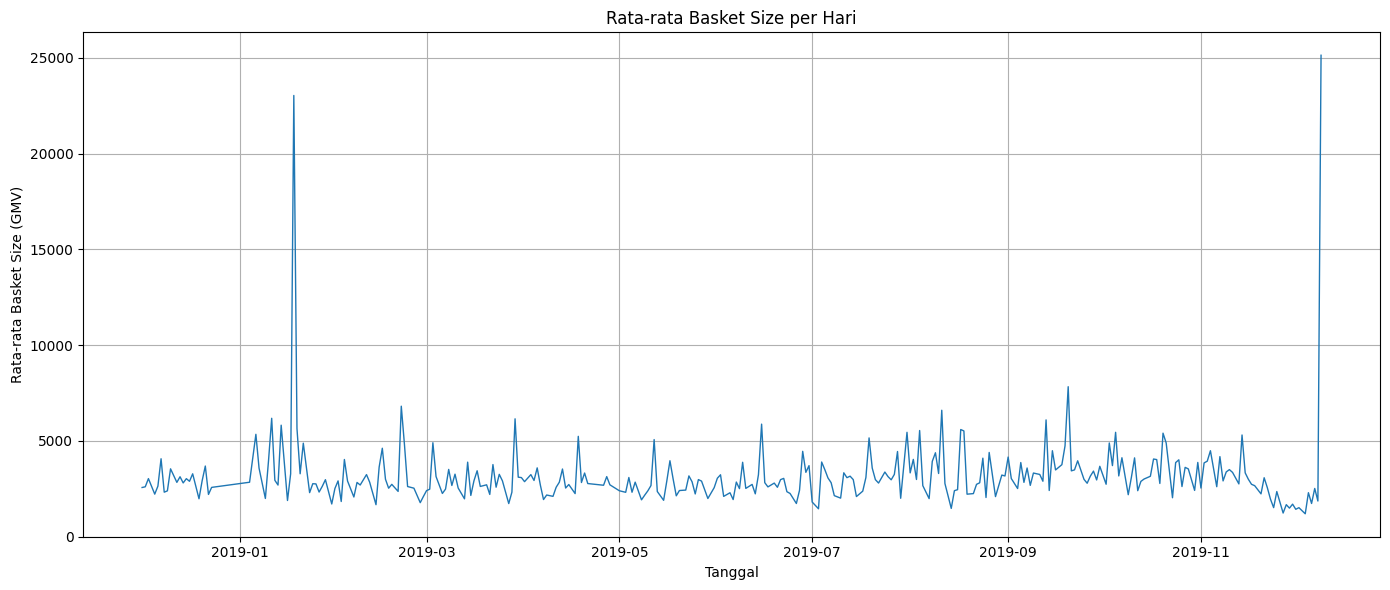

In [34]:
# Plot hasilnya
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
plt.plot(avg_basket_per_day['Date'], avg_basket_per_day['AverageBasketSize'], linewidth=1)
plt.title('Rata-rata Basket Size per Hari')
plt.xlabel('Tanggal')
plt.ylabel('Rata-rata Basket Size (GMV)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
# Tampilkan 10 hari dengan rata-rata basket tertinggi
top10_hari = avg_basket_per_day.sort_values(by='AverageBasketSize', ascending=False).head(10)
print("\nTop 10 Hari dengan Rata-rata Basket Size Tertinggi:")
print(top10_hari)

# Tampilkan 10 hari dengan rata-rata basket terendah
bottom10_hari = avg_basket_per_day.sort_values(by='AverageBasketSize', ascending=True).head(10)
print("\nTop 10 Hari dengan Rata-rata Basket Size Terendah:")
print(bottom10_hari)


Top 10 Hari dengan Rata-rata Basket Size Tertinggi:
          Date  AverageBasketSize
304 2019-12-09       25137.226591
32  2019-01-18       23037.104390
235 2019-09-20        7827.298143
61  2019-02-21        6809.509459
202 2019-08-11        6597.479254
26  2019-01-11        6177.537586
92  2019-03-29        6149.644839
229 2019-09-13        6093.260448
153 2019-06-15        5871.697797
29  2019-01-14        5816.961489

Top 10 Hari dengan Rata-rata Basket Size Terendah:
          Date  AverageBasketSize
299 2019-12-04        1189.638939
293 2019-11-27        1229.122632
297 2019-12-01        1425.152049
168 2019-07-03        1451.829600
204 2019-08-14        1471.310400
295 2019-11-29        1485.881259
298 2019-12-02        1509.503000
291 2019-11-24        1511.461696
54  2019-02-13        1664.980000
294 2019-11-28        1666.234035


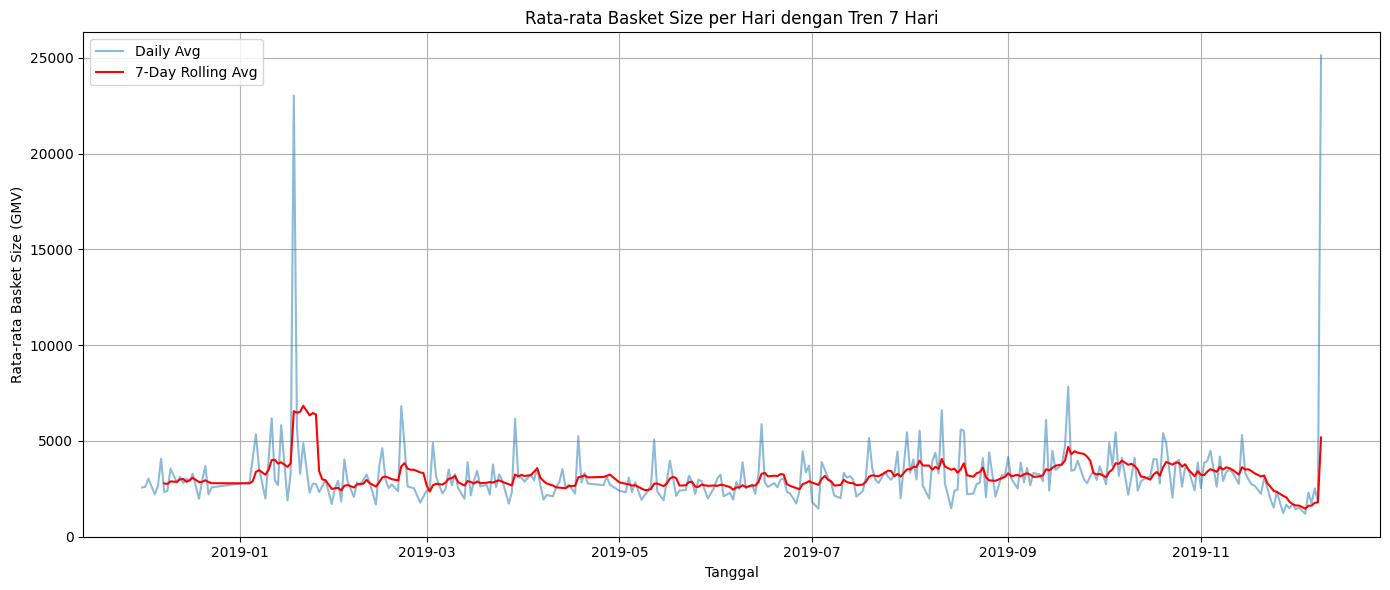

In [40]:
# Tambahkan kolom rolling average 7 hari
avg_basket_per_day['Rolling7DayAvg'] = avg_basket_per_day['AverageBasketSize'].rolling(window=7).mean()

# Plot dengan rolling average
plt.figure(figsize=(14, 6))
plt.plot(avg_basket_per_day['Date'], avg_basket_per_day['AverageBasketSize'], label='Daily Avg', alpha=0.5)
plt.plot(avg_basket_per_day['Date'], avg_basket_per_day['Rolling7DayAvg'], label='7-Day Rolling Avg', color='red')
plt.title('Rata-rata Basket Size per Hari dengan Tren 7 Hari')
plt.xlabel('Tanggal')
plt.ylabel('Rata-rata Basket Size (GMV)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Kesimpulan Pertanyaan Nomor 1 (Basket Size Analysis):
1. Rata-rata basket size per hari adalah sekitar 3.212
2. Basket size harian (daily avg) sangat fluktuatif dengan banyak lonjakan tajam dan penurunan mendadak. Ini menunjukkan bahwa beberapa hari memiliki transaksi dengan nilai sangat besar (outlier), kemungkinan karena promo besar, campaign, atau event tertentu.
3. Rentang nilai yang lebar dengan yang terendah sekitar 1.190 dan yang tertinggi mencapai 25.137. Perbedaan signifikan antara kuartil bawah (Q1 = 2.405) dan kuartil atas (Q3 = 3.496) juga menunjukkan fluktuasi harian yang cukup besar.


#### Insight Pertanyaan Nomor 1 (Basket Size Analysis):
1. Lonjakan besar di awal Januari dan akhir Desember. Kemungkinan besar disebabkan oleh event musiman, seperti Natal & Tahun baru.
2. Evaluasi efektivitas program bundling atau upselling, karena dapat membantu menaikkan rata-rata nilai transaksi.
3. Menyesuaikan stok barang menjelang periode dengan basket size tinggi.

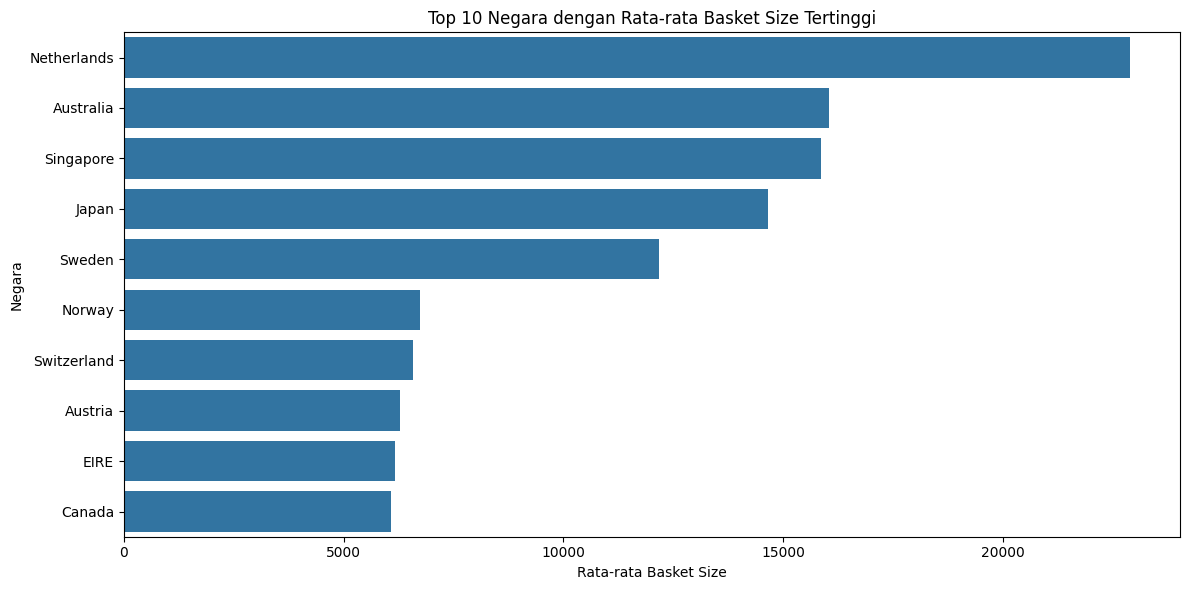

In [41]:
# Hitung GMV per transaksi per negara
basket_by_country = df_sales.groupby(['Country', 'TransactionNo']).agg({
    'GMV': 'sum'
}).reset_index()

# Hitung rata-rata basket size per negara
avg_basket_by_country = basket_by_country.groupby('Country')['GMV'].mean().reset_index()
avg_basket_by_country.columns = ['Country', 'AverageBasketSize']

# Tampilkan negara dengan basket size tertinggi
avg_basket_by_country = avg_basket_by_country.sort_values(by='AverageBasketSize', ascending=False)

# Visualisasikan
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_basket_by_country.head(10), x='AverageBasketSize', y='Country')
plt.title('Top 10 Negara dengan Rata-rata Basket Size Tertinggi')
plt.xlabel('Rata-rata Basket Size')
plt.ylabel('Negara')
plt.tight_layout()
plt.show()

#### Kesimpulan Pertanyaan Nomor 2 (Basket Size Analysis):
1. Dari Grafik di atas, kita bisa melihat bahwa terdapat perbedaan yang cukup signifikan dalam basket size dari negara yang berbeda.
2. Negara seperti Belanda, Australia, dan Singapura memiliki basket size yang jauh lebih besar dibandingkan negara seperti EIRE atau Kanada.


#### Insight Pertanyaan Nomor 2 (Basket Size Analysis):
1. Perbedaan basket size di tiap negara dapat dikarenakan faktor-faktor seperti:
- Tingkat pendapatan per kapita
- Kebiasaan berbelanja
- Ketersediaan produk
2. Negara dengan basket size tinggi dapat menjadi target utama untuk produk high-value atau bundling promo.
3. Retailer bisa menyesuaikan strategi logistik dan inventory berdasarkan basket size rata-rata tiap negara.

# Crucial Question

Ini adalah 5 pertanyaan utama yang ditanyakan oleh pembuat dataset sales ini.  
Anda dapat menggunakan analisis yang sudah dikerjakan pada bagian sebelumnya, ataupun melakukan analisis baru untuk menjawab pertanyaan dibawah.

1. How was the sales trend over the months?
2. What are the most frequently purchased products?
3. How many products does the customer purchase in each transaction?
4. What are the most profitable segment customers?
5. Based on your findings, what strategy could you recommend to the business to gain more profit?

## Jawaban:

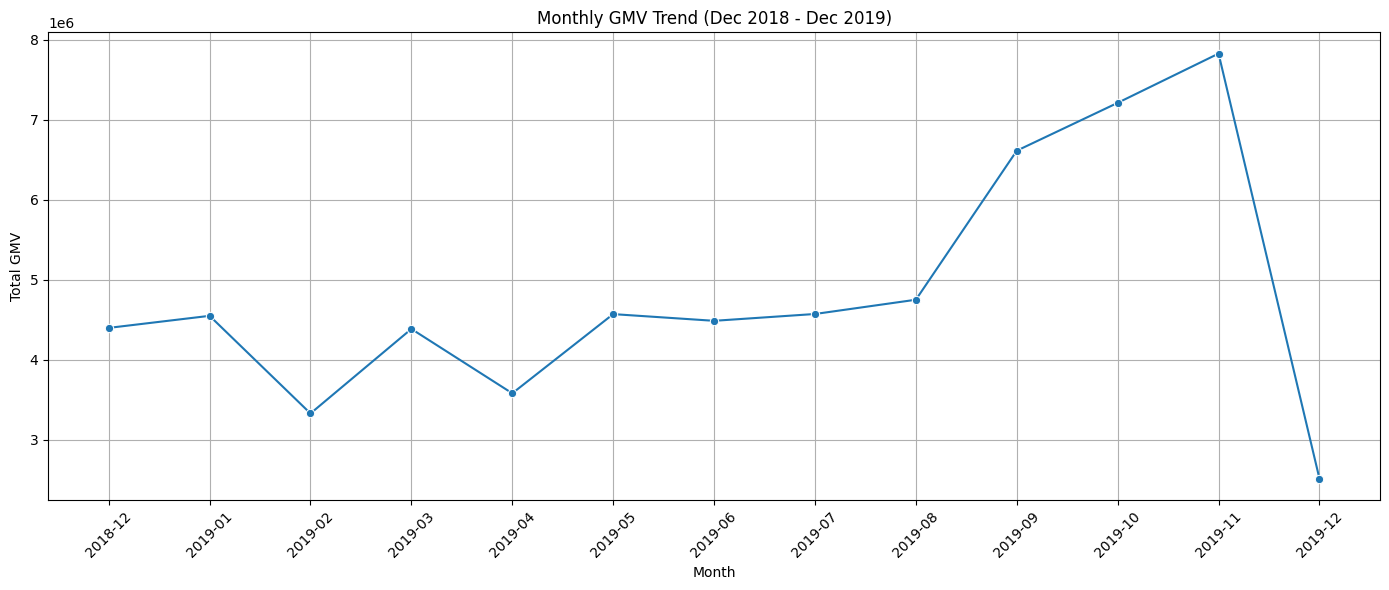

,OrderMonth,TotalQuantity,TotalGMV
0,2018-12,357407,4397648.39
1,2019-01,386332,4548423.47
2,2019-02,282587,3327342.64
3,2019-03,376809,4384669.82
4,2019-04,307509,3579310.06
5,2019-05,394572,4569952.21
6,2019-06,388543,4486132.15
7,2019-07,398750,4571494.88
8,2019-08,421286,4749801.23
9,2019-09,568844,6613772.79


In [42]:
# Pastikan kolom Date sudah dalam format datetime
df_sales['Date'] = pd.to_datetime(df_sales['Date'], dayfirst=True)

# Tambahkan kolom GMV (Gross Merchandise Value)
df_sales['GMV'] = df_sales['Price'] * df_sales['Quantity']

# Buat kolom bulanan (format: YYYY-MM)
df_sales['OrderMonth'] = df_sales['Date'].dt.to_period('M').astype(str)

# Agregasi GMV dan Quantity per bulan
monthly_trend = df_sales.groupby('OrderMonth').agg(
    TotalQuantity=('Quantity', 'sum'),
    TotalGMV=('GMV', 'sum')
).reset_index()

# Plot trend GMV bulanan
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_trend, x='OrderMonth', y='TotalGMV', marker='o')
plt.xticks(rotation=45)
plt.title('Monthly GMV Trend (Dec 2018 - Dec 2019)')
plt.xlabel('Month')
plt.ylabel('Total GMV')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print sebagai alternatif visual
monthly_trend

#### Kesimpulan Pertanyaan Nomor 1 (Crucial Questions):
1. Bulan penjualan tertinggi terjadi di:
- November 2019: Quantity = 760.175, GMV = Rp7.828.489,53.
- Oktober 2019 dan September 2019 juga menunjukkan lonjakan signifikan.

2. Bulan dengan GMV terendah adalah Desember 2019, menurun drastis setelah puncak November.

3. Tren meningkat stabil dari Januari hingga puncak di November 2019, lalu drop tajam di Desember.

#### Insight Pertanyaan Nomor 1 (Crucial Questions):
1. Musim belanja akhir tahun (Q4) adalah pendorong utama pendapatan — manfaatkan strategi promosi besar-besaran pada Q4, terutama saat September s/d November, sehingga ideal untuk kampanye diskon, bundling, dan marketing.

2. Penurunan tajam di Desember kemungkinan karena:
- Waktu liburan panjang, warehouse shutdown, atau stok habis.
- Disarankan evaluasi kapasitas stok agar Desember bisa tetap performa tinggi.

3. Bisa dilakukan perbandingan strategi promosi antar bulan untuk mengetahui taktik yang sukses.

In [43]:
# Agregasi total quantity per product
top_products = df_sales.groupby('ProductName')['Quantity'].sum().reset_index()

# Urutkan dari yang terbanyak
top_products = top_products.sort_values(by='Quantity', ascending=False)

# Tampilkan 10 produk teratas
print("Top 10 Produk yang Paling Sering Dibeli:")
top_products.head(10)

Top 10 Produk yang Paling Sering Dibeli:


,ProductName,Quantity
2203,Paper Craft Little Birdie,80995
1887,Medium Ceramic Top Storage Jar,78033
2481,Popcorn Holder,56902
3670,World War 2 Gliders Asstd Designs,54951
1672,Jumbo Bag Red Retrospot,48375
825,Cream Hanging Heart T-Light Holder,37937
2157,Pack Of 72 Retrospot Cake Cases,36492
203,Assorted Colour Bird Ornament,36394
2540,Rabbit Night Light,30742
1938,Mini Paint Set Vintage,26633


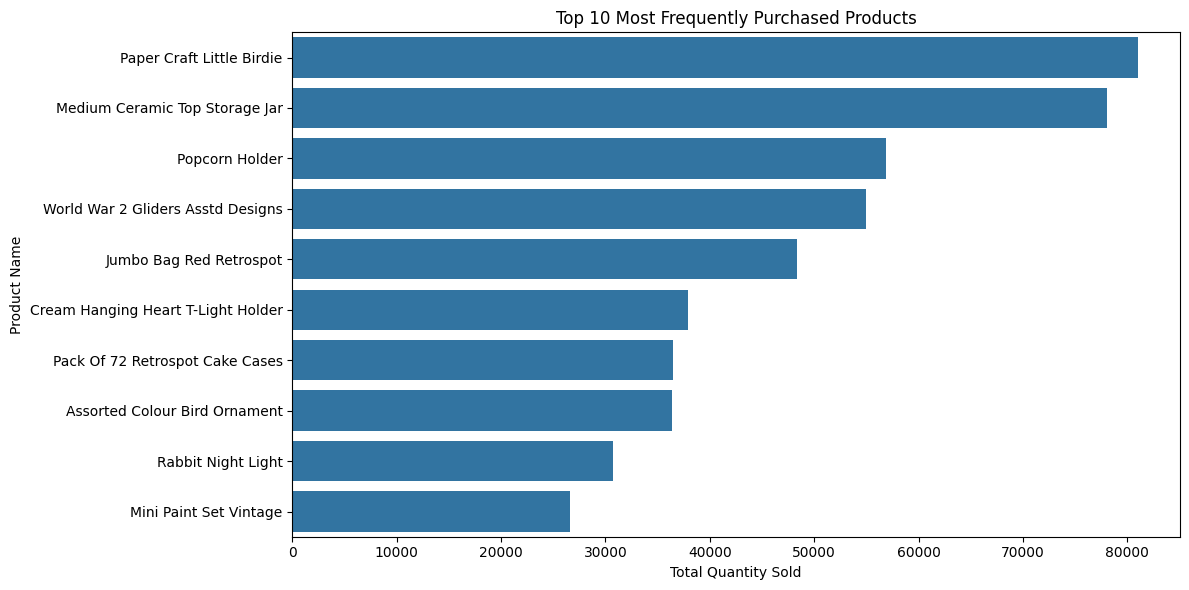

In [44]:
plt.figure(figsize=(12, 6))
sns.barplot(data=top_products.head(10), x='Quantity', y='ProductName')
plt.title('Top 10 Most Frequently Purchased Products')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product Name')
plt.tight_layout()
plt.show()

#### Kesimpulan Pertanyaan Nomor 2 (Crucial Questions):
1. Produk dengan quantity penjualan tertinggi:

- Paper Craft Little Birdie: 80.995 unit
- Medium Ceramic Top Storage Jar: 78.033 unit
- Popcorn Holder: 56.902 unit

2. Sebagian besar produk adalah barang kecil, lucu, dan dekoratif, sehingga cocok untuk gift atau impulse buying.

3. Produk dengan packaging menarik (seperti “Retrospot” atau “Vintage”) muncul berulang kali.



#### Insight Pertanyaan Nomor 2 (Crucial Questions):
1. Produk dekoratif dan unik memiliki daya tarik besar → peluang untuk memperluas variasi desain dan tema.

2. Fokus pada kategori produk dengan keyword seperti:
“Craft”, “Vintage”, “Retrospot”, “Jar”, “Hanging”, “Mini”, “Night Light”

3. Produk dengan penjualan tinggi bisa dijadikan:

- Hero product untuk promosi bundle.
- Fokus untuk re-stocking prioritas

3. Evaluasi apakah produk-produk ini memiliki margin yang tinggi. Jika tidak, pastikan volume penjualannya sepadan dengan effort dan biaya logistik.

In [45]:
products_per_transaction = df_sales.groupby('TransactionNo')['Quantity'].sum().reset_index(name='TotalProducts')
# Urutkan dari yang terbanyak
products_per_transaction = products_per_transaction.sort_values(by='TotalProducts', ascending=False)

# Tampilkan 10 produk teratas
print("Top 10 Transaksi yang Paling banyak Produk:")
products_per_transaction.head(10)

Top 10 Transaksi yang Paling banyak Produk:


,TransactionNo,TotalProducts
19754,581483,80995
2108,541431,74215
8847,556917,15049
11554,563076,14730
16768,574941,14149
17416,576365,13956
15466,572035,13392
13435,567423,12572
18552,578841,12540
7047,552883,12266


<ipython-input-46-5652b5d8f662>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


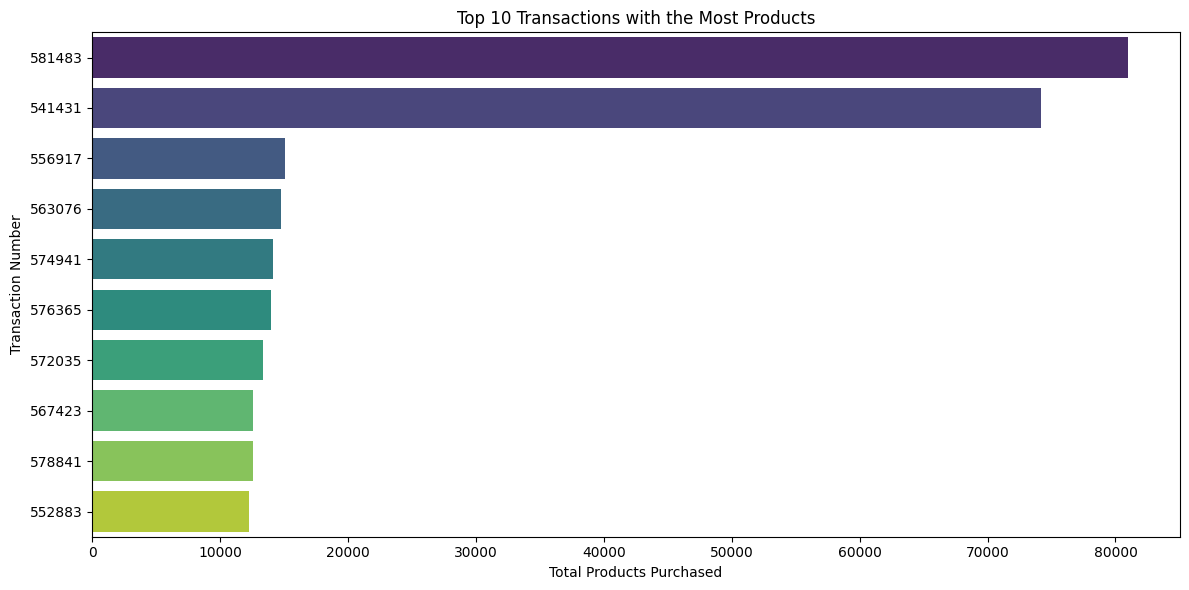

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ambil 10 transaksi teratas berdasarkan total produk
top_10_transactions = products_per_transaction.head(10)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_10_transactions,
    x='TotalProducts',
    y='TransactionNo',
    palette='viridis'
)
plt.title('Top 10 Transactions with the Most Products')
plt.xlabel('Total Products Purchased')
plt.ylabel('Transaction Number')
plt.tight_layout()
plt.show()

#### Kesimpulan Pertanyaan Nomor 3 (Crucial Questions):
1. Dalam satu transaksi, jumlah produk yang dibeli oleh pelanggan bisa sangat besar.

2. Contohnya, transaksi dengan ID 581483 mencatatkan 80.995 produk dalam satu kali pembelian, yang merupakan jumlah tertinggi.

3. Transaksi-transaksi lain dalam 10 besar juga menunjukkan pembelian ribuan produk dalam satu transaksi.



#### Insight Pertanyaan Nomor 3 (Crucial Questions):
1. Jumlah pembelian produk yang sangat besar per transaksi ini menunjukkan adanya bulk buying behavior—kemungkinan besar transaksi ini dilakukan oleh pelanggan reseller, distributor, atau pelanggan korporat.

2. Buat program loyalitas khusus atau diskon untuk pembelian dalam jumlah besar.

3. Perlu dicek lebih lanjut apakah transaksi besar ini konsisten dilakukan oleh pelanggan tertentu atau hanya sekali-sekali.

In [52]:
import pandas as pd

# Pastikan kolom Date dalam format datetime
df_sales['Date'] = pd.to_datetime(df_sales['Date'], dayfirst=True)

# Tambahkan kolom Revenue
df_sales['Revenue'] = df_sales['Price'] * df_sales['Quantity']

# Tentukan tanggal acuan (misal: 1 hari setelah transaksi terakhir)
snapshot_date = df_sales['Date'].max() + pd.Timedelta(days=1)

# Group by CustomerNo untuk menghitung RFM
rfm = df_sales.groupby('CustomerNo').agg({
    'Date': lambda x: (snapshot_date - x.max()).days,  # Recency
    'TransactionNo': 'nunique',                        # Frequency
    'Revenue': 'sum'                                   # Monetary
}).reset_index()

# Rename kolom
rfm.columns = ['CustomerNo', 'Recency', 'Frequency', 'Monetary']

# Buat skor R, F, M (1–4, quantile-based)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

# Gabungkan RFM Score
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Hitung RFM Score total (untuk segmentasi kasar)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].astype(int).sum(axis=1)

# Tampilkan 10 pelanggan teratas berdasarkan RFM Score
rfm.sort_values(by='RFM_Score', ascending=False).head(10)

,CustomerNo,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
4678,18230.0,10,7,15495.40,4,4,4,444,12
2294,15172.0,9,5,15752.32,4,4,4,444,12
4707,18272.0,3,6,22758.63,4,4,4,444,12
4611,18144.0,8,12,15681.22,4,4,4,444,12
4659,18210.0,2,6,14888.30,4,4,4,444,12
4652,18198.0,5,17,46294.34,4,4,4,444,12
4639,18180.0,5,6,17879.32,4,4,4,444,12
4638,18179.0,10,6,13570.29,4,4,4,444,12
2285,15159.0,2,30,129213.38,4,4,4,444,12
2279,15152.0,10,13,29483.43,4,4,4,444,12


Segmentasi Customer berdasarkan RFM Score:
- 9 - 12	Best Customers
- 7 - 8	Loyal Customers
- 5 - 6	Potential Loyalist / At Risk
- 3 - 4	Needs Attention / Low Value

In [56]:
# Buat kolom segment baru berdasarkan RFM_Score
def assign_segment(score):
    if score >= 9:
        return 'Best Customers'
    elif score >= 7:
        return 'Loyal Customers'
    elif score >= 5:
        return 'Potential Loyalist / At Risk'
    else:
        return 'Needs Attention / Low Value'

rfm['Segment'] = rfm['RFM_Score'].apply(assign_segment)

# Hitung total revenue per segment
revenue_per_segment = rfm.groupby('Segment')['Monetary'].sum().reset_index()

# Urutkan berdasarkan revenue tertinggi
revenue_per_segment = revenue_per_segment.sort_values(by='Monetary', ascending=False)

revenue_per_segment

,Segment,Monetary
0,Best Customers,50623626.34
1,Loyal Customers,6711082.27
3,Potential Loyalist / At Risk,4396460.87
2,Needs Attention / Low Value,1050135.06


<ipython-input-57-982f12d41a24>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_summary, x='Segment', y='Monetary', palette='viridis')


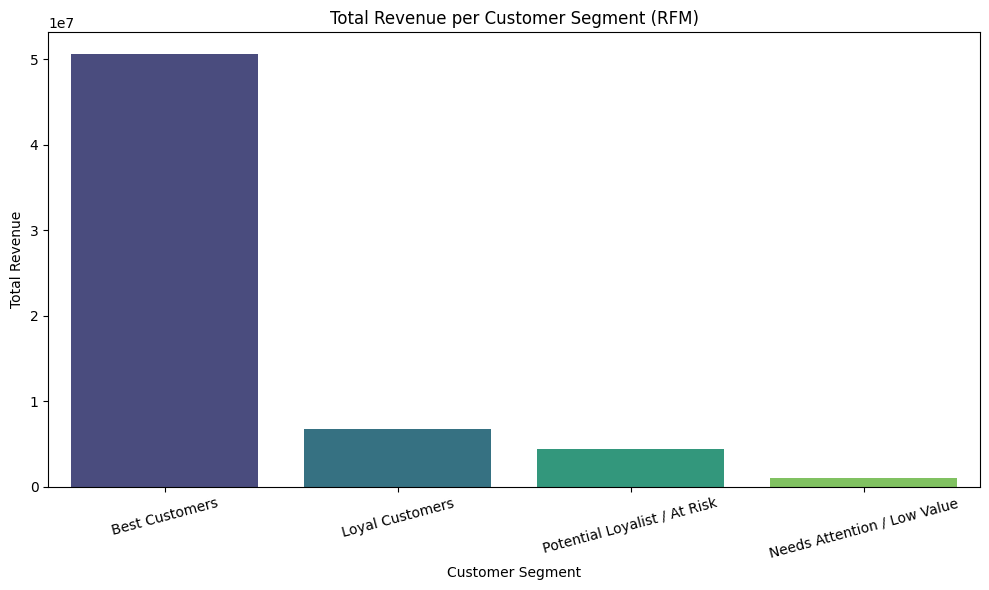

In [57]:
# Hitung total revenue per segment
segment_summary = rfm.groupby('Segment')['Monetary'].sum().reset_index()
segment_summary = segment_summary.sort_values(by='Monetary', ascending=False)

# Visualisasi
plt.figure(figsize=(10, 6))
sns.barplot(data=segment_summary, x='Segment', y='Monetary', palette='viridis')
plt.title('Total Revenue per Customer Segment (RFM)')
plt.ylabel('Total Revenue')
plt.xlabel('Customer Segment')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

#### Kesimpulan Pertanyaan Nomor 4 (Crucial Questions):
1. Segmen "Best Customers" merupakan kontributor terbesar terhadap total revenue dengan nilai sebesar 50.62 juta.

2. Disusul oleh "Loyal Customers" dengan kontribusi revenue sebesar 6.71 juta.

3. Segmen lain seperti "Potential Loyalist / At Risk" dan "Needs Attention / Low Value" memberikan kontribusi jauh lebih kecil terhadap total pendapatan.


#### Insight Pertanyaan Nomor 4 (Crucial Questions):
1. Karena segmen "Best Cutomers" menyumbang hampir 70% dari total revenue, penting untuk menjaga loyalitas mereka dengan membuat program loyalty atau VIP tier atau memberikan early access, personalized offers, atau exclusive discounts.

2. Memberikan incentive tambahan kepada segmen "Loyal Customers" untuk meningkatkan spending (monetary) mereka.

3. Meningkatkan engagement segmen "Potential Loyalist / At Risk" dengan mengirim reminder email atau tawarkan diskon terbatas

4. Mengevaluasi kembali segmen "Needs Attention / Low Value" karena segmen ini memiliki kontribusi revenue yang paling rendah. Dapat melakukan segmentasi lebih dalam, apakah mereka benar-benar tidak potensial atau hanya belum aktif.

#### Strategi yang direkomendasikan untuk meningkatkan profit bisnis (Pertanyaan Nomor 5 (Cruscial Questions)):
1. Maksimalkan Potensi “Best Customers” dengan Program Loyalitas Eksklusif

- Mereka menyumbang Rp50,62 juta dari total revenue (kontributor terbesar).
- Memiliki potensi repeat order tinggi dan lebih mudah dipertahankan.

Aksi konkret:

- Buat tiered loyalty program (misal: Gold, Silver, Bronze).
- Berikan benefit eksklusif seperti diskon spesial, akses early bird, atau hadiah ulang tahun.

2. Optimalkan Hari Penjualan Tinggi (Minggu & Jumat) untuk Flash Sale dan Promosi
- Hari Minggu dan Jumat menunjukkan rata-rata penjualan tertinggi (>20.000 unit).
- Peluang besar untuk meningkatkan volume penjualan harian dengan promosi terarah.

Aksi konkret:
- Jalankan Flash Sale hanya di Jumat dan Minggu dengan durasi terbatas.
- Gunakan email & media sosial untuk mendorong traffic di dua hari tersebut.

3. Manfaatkan Produk Musiman (Terutama Natal) untuk Kampanye Penjualan yang Terjadwal
- Banyak produk Super Populer di bulan November adalah produk bertema Natal/liburan.
- Terjadi lonjakan penjualan signifikan di Q4 (Sep - Nov).

Aksi konkret:
- Rancang kampanye tematik jauh sebelum musim puncak (misal: “Christmas in July” promo).
- Sediakan bundling dan diskon spesial untuk produk musiman yang terbukti laku.




